  # 基于Duconv的对话系统
  ### 虽然人机对话已经取得了巨大的进展，但目前对于对话系统的研究还处于起步阶段，这是因为现在研究的智能体通常只能进行被动的，它所进行的对话更多的是为了回应，而不是自己主动。在论文《Proactive Human-Machine Conversation with Explicit Conversation Goals》中，作者创新性地构建了一个更类似人的对话智能体：赋予它主动引导对话的能力（引入一个新的主题或保持当前的主题）。
   ### 为了促进该对话系统的开发，论文作者创建了一个名为DuConv的新数据集，该数据集有两个交流者，其中一个作为对话的领导者，另一个作为追随者。领导者会被提供一个知识图，并被要求按照给定的对话目标，在保证对话尽可能自然的情况下，按照顺序去改变讨论的主题。
   ### DuConv数据集不但提供了对话，还提供了丰富多样的知识图。因此在研究基于DuConv数据集的对话系统时，所建立的模型既需要理解对话，又需要对给定的知识图进行规划。作者在建立模型时将现今最先进的几个模型进行融合，从而进行模型的训练。最终得出结论：在知识图上进行规划的对话模型可以充分利用相关知识，生成更多样化的多回合对话。
   ### 基于DuConv的知识感知模型分为基于检索的模型和基于生成的模型。Retrieval-based 模型中的编码器具有与Bert相同的结构，并且引入双向GPU的向量表示，使用Transformer方法进行编码表示，再联合attention方法选取的相关知识信息通过softmax层进行二分类判断。Generation-based知识感知模型通过引入先验分布和后验分布，同时引入attention机制以及使用两种不同的损失函数来分别衡量模型输出和真实输出差异、真实输出和相外部知识的差异。与传统的seq2seq模型相比，Retrieval-based 模型和Generation-based 模型都具有更好的性能，可以利用DuConv数据集中更多的知识图谱来实现引导对话的目标，并且同时保证生成的对话自然连贯。本次应用案例实现的是基于DuConv 数据集的Retrieval-based 模型。
   
   
   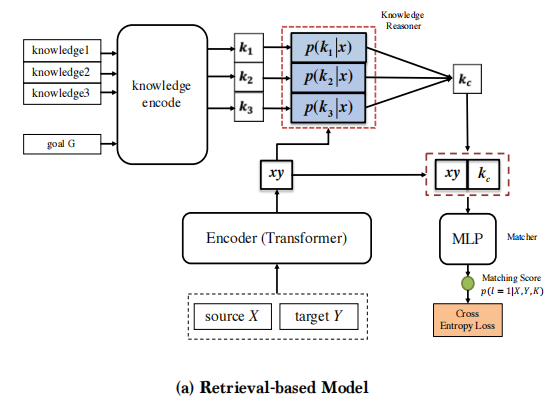
   ## 给定一个对话上下文X，基于检索的模型通过搜索从DuConv中获得的最佳回复Y来回复X。
### 因此，基于检索的模型有两个主要步骤：
### 从数据库中检索候选回复；
### 从候选回复中选择最佳回复。

#### 导入所需的库

In [1]:
import sys
import json
import collections
import math
import time
import argparse
import mindspore
import os
import functools
import numpy as np
import random
import mindspore.common.dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.nn as nn
import mindspore.ops as P
import mindspore.numpy as mnp
import mindspore.common.dtype as mstype
from mindspore.nn.learning_rate_schedule import LearningRateSchedule
from mindspore import Tensor
from mindspore import log as logger
from mindspore.train.callback import Callback
from numpy.lib.function_base import average
from mindspore.common.tensor import Tensor
from mindspore.common.initializer import Zero, TruncatedNormal, Constant
from mindspore.nn.layer import activation
from mindspore import context
from mindspore.nn.optim import Adam
from mindspore.train.model import Model
from mindspore.nn import TrainOneStepCell
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, LossMonitor
import mindspore.ops.operations as P
from mindspore.train.serialization import load_checkpoint, load_param_into_net




#### 创建与数据集存储结构
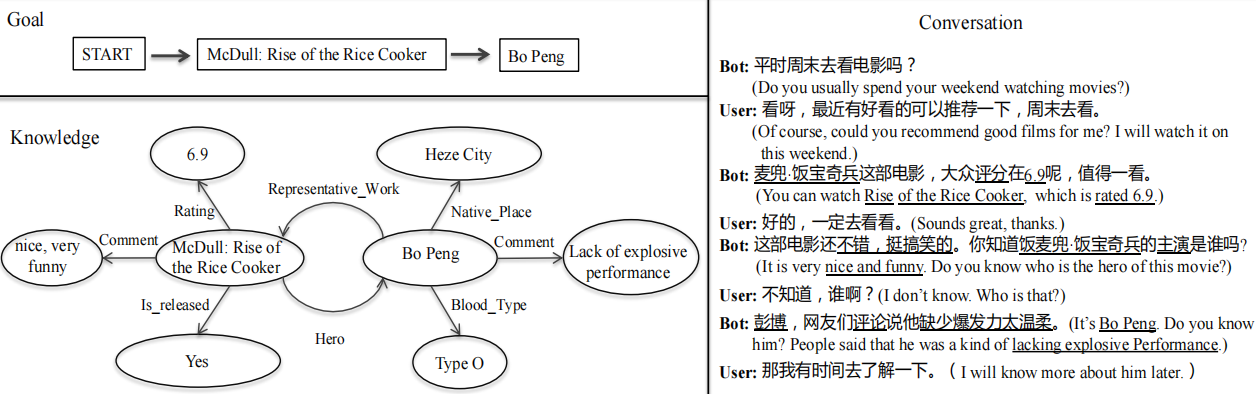

In [2]:
def create_dataset(batch_size, device_num=1, rank=0, do_shuffle=True, data_file_path=None, use_knowledge=False):
    """create train dataset"""
    if use_knowledge:
        colums_list = ["context_id", "context_segment_id", "context_pos_id", "kn_id", "kn_seq_length", "labels_list"]
    else:
        colums_list = ["context_id", "context_segment_id", "context_pos_id", "labels_list"]

    # apply repeat operations
    data_set = ds.MindDataset(data_file_path,
                              columns_list=colums_list,
                              shuffle=do_shuffle,
                              num_shards=device_num,
                              shard_id=rank
                              )

    ori_dataset_size = data_set.get_dataset_size()
    print('origin dataset size: ', ori_dataset_size)
    type_cast_op = C.TypeCast(mstype.int32)
    data_set = data_set.map(operations=type_cast_op, input_columns="context_id")
    data_set = data_set.map(operations=type_cast_op, input_columns="context_pos_id")
    data_set = data_set.map(operations=type_cast_op, input_columns="context_segment_id")
    data_set = data_set.map(operations=type_cast_op, input_columns="labels_list")
    if use_knowledge:
        data_set = data_set.map(operations=type_cast_op, input_columns="kn_id")
        data_set = data_set.map(operations=type_cast_op, input_columns="kn_seq_length")
    # apply batch operations
    data_set = data_set.batch(batch_size, drop_remainder=True)
    logger.info("data size: {}".format(data_set.get_dataset_size()))
    logger.info("repeat count: {}".format(data_set.get_repeat_count()))
    return data_set

#### 编码器具有和BERT相同的结构。它将上下文X和候选响应Y作为BERT中的第a段和第b段，并利用堆叠的自注意来产生X和Y的联合表示，记为xy。每个相关知识知识也被编码为知识编码器模块中使用双向GRU的向量表示。知识推理器通过注意力机制来进行知识的选择，最终通过串联来将知识侧和对话侧的信息向量融合在一起，最后计算出匹配的概率并进行排名。
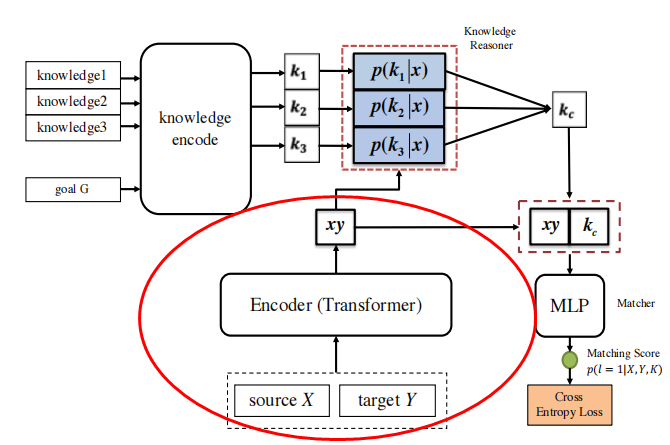

In [3]:
#激活函数
class GELU(nn.Cell):
    def __init__(self):
        super().__init__()
        self.erf = P.Erf()
        self.sqrt = P.Sqrt()
        self.const0 = Tensor(0.5, mindspore.float32)
        self.const1 = Tensor(1.0, mindspore.float32)
        self.const2 = Tensor(2.0, mindspore.float32)

    def construct(self, x):
        return x * self.const0 * (self.const1 + self.erf(x / self.sqrt(self.const2)))

#用在transformer的attention机制中，在时序任务中，主要是用来mask掉当前时刻后面时刻的序列信息。此时的mask主要实现时序上的mask。
class MaskedFill(nn.Cell):
    def __init__(self, value):
        super().__init__()
        self.value = value
        self.select = P.Select()
        self.fill = P.Fill()
        self.cast = P.Cast()

    def construct(self, inputs: Tensor, mask: Tensor):
        mask = self.cast(mask, mstype.bool_)
        masked_value = self.fill(mindspore.float32, inputs.shape, self.value)
        output = self.select(mask, masked_value, inputs)
        return output

#通过dot-product attention注意力机制来计算两者之间的相似度，并引入dropout来防止权重衰减
class ScaledDotProductAttention(nn.Cell):
    def __init__(self, d_k, dropout):
        super().__init__()
        self.scale = Tensor(d_k, mindspore.float32)
        self.matmul = nn.MatMul()
        self.transpose = P.Transpose()
        self.softmax = nn.Softmax(axis=-1)
        self.sqrt = P.Sqrt()
        self.masked_fill = MaskedFill(-1e9)

        if dropout > 0.0:
            self.dropout = nn.Dropout(1 - dropout)
        else:
            self.dropout = None

    def construct(self, Q, K, V, attn_mask):
        K = self.transpose(K, (0, 1, 3, 2))
        scores = self.matmul(Q, K) / self.sqrt(
            self.scale)  # 得分 : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores = self.masked_fill(scores, attn_mask)  # 用掩码为1的值填充自张量的元素.
        # scores = scores + attn_mask
        attn = self.softmax(scores)
        context = self.matmul(attn, V)
        if self.dropout is not None:
            context = self.dropout(context)
        return context, attn

#将attention的计算并行化
class MultiHeadAttention(nn.Cell):
    def __init__(self, d_model, n_heads, dropout, initializer_range=0.02):
        super().__init__()
        self.n_heads = n_heads
        self.W_Q = nn.Dense(d_model, d_model)
        self.W_K = nn.Dense(d_model, d_model)
        self.W_V = nn.Dense(d_model, d_model)
        self.linear = nn.Dense(d_model, d_model)
        self.head_dim = d_model // n_heads
        assert self.head_dim * n_heads == d_model, "embed_dim must be divisible by num_heads"
        self.layer_norm = nn.LayerNorm((d_model,), epsilon=1e-6)
        self.attention = ScaledDotProductAttention(self.head_dim, dropout)
        # ops
        self.transpose = P.Transpose()
        self.expanddims = P.ExpandDims()
        self.tile = P.Tile()

    def construct(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.shape[0]
        q_s = self.W_Q(Q).view((batch_size, -1, self.n_heads, self.head_dim))
        k_s = self.W_K(K).view((batch_size, -1, self.n_heads, self.head_dim))
        v_s = self.W_V(V).view((batch_size, -1, self.n_heads, self.head_dim))
        q_s = self.transpose(q_s, (0, 2, 1, 3))  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.transpose(k_s, (0, 2, 1, 3))  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.transpose(v_s, (0, 2, 1, 3))  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = self.expanddims(attn_mask, 1)
        attn_mask = self.tile(attn_mask, (1, self.n_heads, 1, 1))  

       
        context, attn = self.attention(q_s, k_s, v_s, attn_mask)
        context = self.transpose(context, (0, 2, 1, 3)).view(
            (batch_size, -1, self.n_heads * self.head_dim))  
        output = self.linear(context)
        return self.layer_norm(output + residual), attn 


activation_map = {
    'relu': nn.ReLU(),
    'gelu': GELU(),
}

#将掩码进行隐藏，返回一个大小和 seq_k 一样的 tensor，只不过里面的值只有 True 和 False。
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.shape
    batch_size, len_k = seq_k.shape

    pad_attn_mask = P.ExpandDims()(P.Equal()(seq_k, 0), 1)
    pad_attn_mask = P.Cast()(pad_attn_mask, mstype.int32)
    pad_attn_mask = P.BroadcastTo((batch_size, len_q, len_k))(pad_attn_mask)
    return pad_attn_mask

#配置bert模型的参数
class BertConfig:
    def __init__(self,
                 seq_length=256,
                 vocab_size=32000,#字典大小
                 hidden_size=256,
                 num_hidden_layers=4,#隐藏层数
                 num_attention_heads=8,#每个attention层的attention头数
                 intermediate_size=1024,#encoder中的中间层的维度
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,#embedding, encoder, pooler部分里全连接层的dropout概率
                 attention_probs_dropout_prob=0.1,#attention过程中softmax后的概率计算时的dropout概率
                 max_position_embeddings=256,#模型允许的最大序列长度
                 type_vocab_size=2,
                 initializer_range=0.02):
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

#attention 结构中的 FeedForward 组件, 由2个1x1的卷积形成
class PoswiseFeedForwardNet(nn.Cell):
    def __init__(self, d_model, d_ff, activation: str = 'gelu', initializer_range=0.02, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Dense(d_model, d_ff)
        self.fc2 = nn.Dense(d_ff, d_model)
        self.activation = activation_map.get(activation, nn.GELU())
        self.layer_norm = nn.LayerNorm((d_model,), epsilon=1e-6)
        self.dropout = nn.Dropout(1 - dropout)

    def construct(self, inputs):
        residual = inputs
        outputs = self.fc1(inputs)
        outputs = self.activation(outputs)

        outputs = self.fc2(outputs)
        outputs = self.dropout(outputs)
        return self.layer_norm(outputs + residual)

#建立一个从one-hot编码到m维的稠密向量的映射
class BertEmbeddings(nn.Cell):
    def __init__(self, config):
        super().__init__()
        self.tok_embed = nn.Embedding(config.vocab_size, config.hidden_size)
        self.pos_embed = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.seg_embed = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.norm = nn.LayerNorm((config.hidden_size,), epsilon=1e-6)
        self.dropout = nn.Dropout(1 - config.hidden_dropout_prob)

        self.expand_dims = P.ExpandDims()

    def construct(self, x, seg, pos=None):
        seq_len = x.shape[1]
        if pos is None:
            pos = mnp.arange(seq_len)
            pos = P.BroadcastTo(x.shape)(self.expand_dims(pos, 0))
        seg_embedding = self.seg_embed(seg)
        tok_embedding = self.tok_embed(x)
        embedding = tok_embedding + self.pos_embed(pos) + seg_embedding
        embedding = self.norm(embedding)
        embedding = self.dropout(embedding)
        return embedding

#bert的编码器中隐藏层的定义
class BertEncoderLayer(nn.Cell):
    def __init__(self, d_model, n_heads, d_ff, activation, attention_dropout, dropout):
        super().__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads, attention_dropout)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff, activation, dropout)

    def construct(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn

#定义了一个 Bert 的encoder层，然后将这个encoder层复制了N层。使用for循环让数据依次通过每一个encoder，然后根据输出决定是否返回每一层encoder的输出
class BertEncoder(nn.Cell):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.CellList([
            BertEncoderLayer(config.hidden_size,
                             config.num_attention_heads,
                             config.intermediate_size,
                             config.hidden_act,
                             config.attention_probs_dropout_prob,
                             config.hidden_dropout_prob)
            for _ in range(config.num_hidden_layers)
        ])

    def construct(self, inputs, enc_self_attn_mask):
        outputs = inputs
        for layer in self.layers:
            outputs, enc_self_attn = layer(outputs, enc_self_attn_mask)
        return outputs

#加载模型与分词器
class BertModel(nn.Cell):
    def __init__(self, config):
        super().__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = nn.Dense(config.hidden_size, config.hidden_size, activation='tanh')

    def construct(self, input_ids, segment_ids, position_ids=None):
        outputs = self.embeddings(input_ids, segment_ids, position_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        outputs = self.encoder(outputs, enc_self_attn_mask)
        h_pooled = self.pooler(outputs[:, 0])
        return outputs, h_pooled

#### 知识编码器使用的是循环神经网络结构RNN，总体作用是输入序列输入给编码器，然后将生成一个最终的隐藏状态。
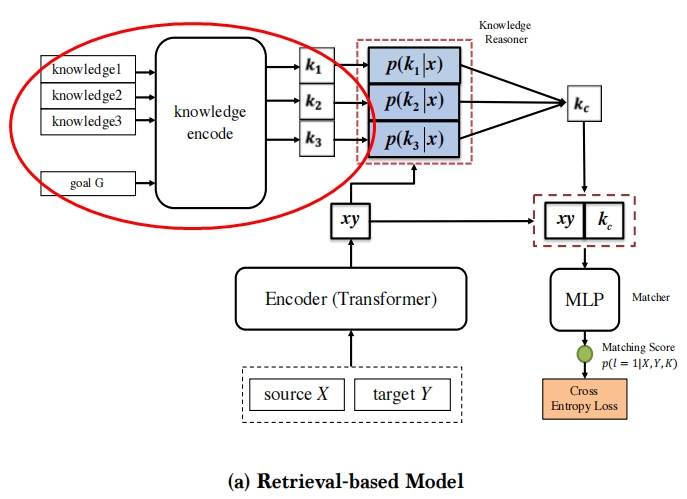

In [4]:
#具有RNN结构的编码器
class RNNEncoder(nn.Cell):
    def __init__(self, input_size, hidden_size, bidirectional, num_layers, dropout=0.0, embeddings=None,
                 use_bridge=False):
        super().__init__()
        assert embeddings is not None

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.bidirectional = bidirectional
        self.embeddings = embeddings
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            batch_first=True
        )


        self.use_bridge = use_bridge
        if self.use_bridge:
            self.total_hidden_dim = hidden_size * num_layers
            self.bridge = nn.Dense(self.total_hidden_dim, self.total_hidden_dim, activation='relu')

    def construct(self, inputs, seq_length):
        emb = self.embeddings(inputs)
        memory_bank, encoder_final = self.rnn(emb, seq_length=seq_length)

        if self.use_bridge:
            shape = encoder_final.shape
            encoder_final = self.bridge(encoder_final.view(-1, self.total_hidden_dim)).view(shape)

        if self.bidirectional:
            batch_size = encoder_final.shape[1]
            encoder_final = encoder_final.view(self.num_layers, 2, batch_size, self.hidden_size) \
                .swapaxes(1, 2).view(self.num_layers, batch_size, self.hidden_size * 2)

        return encoder_final, memory_bank



#### 下面是知识推理模块和匹配模块的结合。首先将候选回复Y和对话历史X（包括当前轮的用户输入）使用分隔符拼接成一串字符序列，然后使用Transformer方法进行编码表示，再联合attention方法选取的相关知识信息通过softmax层进行二分类判断。
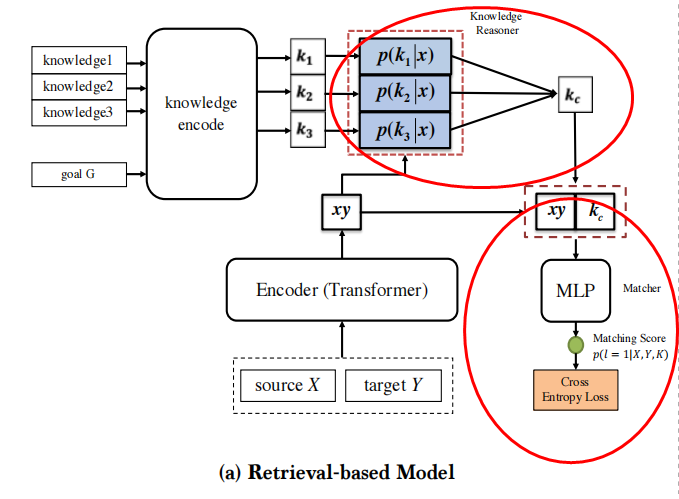
其中p的公式如下图：
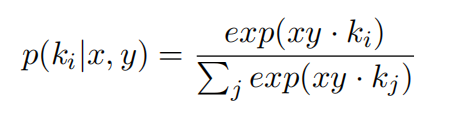

In [5]:
#注意力模型从序列中学习到每一个元素的重要程度，然后按重要程度将元素合并。
class Attention(nn.Cell):
    def __init__(self, memory_size, hidden_size):
        super().__init__()
        self.bmm = P.BatchMatMul()
        self.concat = P.Concat(-1)
        self.softmax = nn.Softmax()
        self.linear_project = nn.SequentialCell([
            nn.Dense(hidden_size + memory_size, hidden_size),
            nn.Tanh()
        ])

    def construct(self, query, memory):
        attn = self.bmm(query, memory.swapaxes(1, 2))
        weights = self.softmax(attn)
        weighted_memory = self.bmm(weights, memory)
        project_output = self.linear_project(self.concat((weighted_memory, query)))
        return project_output

#从训练集中相同对话目标类型相同轮次的机器回复中选取候选回复
class Retrieval(nn.Cell):
    def __init__(self, config, use_kn=False):
        super().__init__()
        self.bert = BertModel(config)
        self.use_kn = use_kn
        if self.use_kn:
            self.kn_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
            self.memory = RNNEncoder(
                config.hidden_size,
                config.hidden_size,
                True,
                1,
                config.hidden_dropout_prob,
                self.kn_embeddings,
                True
            )
            self.attention = Attention(config.hidden_size, config.hidden_size)
        self.fc = nn.Dense(config.hidden_size, 2, weight_init=TruncatedNormal(config.initializer_range))
        self.dropout = nn.Dropout(1 - config.hidden_dropout_prob)

    def construct(self, input_ids, segment_ids, position_ids=None, kn_ids=None, seq_length=None):
        # print(kn_ids)
        if len(seq_length.shape) != 1:
            seq_length = P.Squeeze(1)(seq_length)
        _, h_pooled = self.bert(input_ids, segment_ids, position_ids)
        h_pooled = P.ExpandDims()(h_pooled, 1)
        if self.use_kn:
            _, memory_bank = self.memory(kn_ids, seq_length)
            cls_feats = self.attention(h_pooled, memory_bank)
        else:
            cls_feats = h_pooled
        cls_feats = self.dropout(cls_feats.squeeze(1))
        logits = self.fc(cls_feats)
        # print(cls_feats.shape)
        return logits

#检索模型的损失函数的计算
class RetrievalWithLoss(nn.Cell):
    def __init__(self, config, use_kn):
        super().__init__()
        self.network = Retrieval(config, use_kn)
        self.loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
        self.squeeze = P.Squeeze(1)

    def construct(self, *inputs):
        # print(inputs[-1].shape)
        out = self.network(*inputs[:-1])
        # print(out.shape, inputs[-1].shape)
        labels = self.squeeze(inputs[-1])
        return self.loss(out, labels)

# 归一化指数函数，目的是将多分类的结果以概率的形式展现出来。
class RetrievalWithSoftmax(nn.Cell):
    def __init__(self, config, use_kn):
        super().__init__()
        self.network = Retrieval(config, use_kn)
        self.softmax = nn.Softmax()

    def construct(self, *inputs):
        out = self.network(*inputs)
        out = self.softmax(out)
        return out


#### 将模型参数正则化

In [6]:
class Noam(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps, learning_rate=1.0):
        super().__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.learning_rate = learning_rate
        self.pow = P.Pow()
        self.min = P.Minimum()
        self.cast = P.Cast()
        self.const0 = Tensor(-0.5, mstype.float32)
        self.const1 = Tensor(-1.5, mstype.float32)

    def construct(self, global_step):
        p = self.cast(self.min(
            self.pow(global_step, self.const0),
            self.pow(self.warmup_steps, self.const1) * global_step),
            mstype.float32)
        return self.learning_rate * self.pow(self.d_model, self.const0) * p

#### 模型损失函数的反向传播设置，同时打印输出训练的时间及损失

In [7]:
#对训练时间进行监控，同时输出每一个阶段的耗时
class TimeMonitor(Callback):


    def __init__(self, per_print_times=1):
        super(TimeMonitor, self).__init__()
        self._per_print_times = per_print_times
        self.epoch_time = time.time()
        self.time_list = []

    def step_begin(self, run_context):
        self.epoch_time = time.time()

    def step_end(self, run_context):
        step_seconds = (time.time() - self.epoch_time) * 1000
        self.time_list.append(step_seconds)
        cb_params = run_context.original_args()
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            print("per step time: {:5.3f} ms".format(average(self.time_list)), flush=True)
        self.time_list = []

#对训练损失进行监控，同时输出每epoch的平均损失
class LossCallBack(Callback):
    
    def __init__(self, dataset_size=-1):
        super(LossCallBack, self).__init__()
        self._dataset_size = dataset_size
    def step_end(self, run_context):
        """
        Print loss after each step
        """
        cb_params = run_context.original_args()
        if self._dataset_size > 0:
            percent, epoch_num = math.modf(cb_params.cur_step_num / self._dataset_size)
            if percent == 0:
                percent = 1
                epoch_num -= 1
            print("epoch: {}, current epoch percent: {}, step: {}, outputs are {}"
                  .format(int(epoch_num), "%.3f" % percent, cb_params.cur_step_num, str(cb_params.net_outputs)),
                  flush=True)
        else:
            print("epoch: {}, step: {}, outputs are {}".format(cb_params.cur_epoch_num, cb_params.cur_step_num,
                                                               str(cb_params.net_outputs)), flush=True)


#### 比较序列长短的函数

In [8]:
def cmp(a, b):
    len_a, len_b = len(a[1]), len(b[1])
    if len_a > len_b:
        return 1
    elif len_a < len_b:
        return -1
    else:
        return 0

#### 提取预测的回复进行提取并准备评估。

In [9]:
#将结果存入文件之中
def extract_predict_utterance(sample_file, score_file, output_file):
    """
    convert_result_for_eval
    """
    sample_list = [line.strip() for line in open(sample_file, 'r', encoding="utf-8")]
    score_list = [line.strip() for line in open(score_file, 'r', encoding="utf-8")]

    fout = open(output_file, 'w', encoding="utf-8")
    index = 0
    for i, sample in enumerate(sample_list):
        sample = json.loads(sample, encoding="utf-8", object_pairs_hook=collections.OrderedDict)

        candidates = sample["candidate"]
        scores = score_list[index: index + len(candidates)]

        pridict = candidates[0]
        max_score = float(scores[0])
        for j, score in enumerate(scores):
            score = float(score)
            if score > max_score:
                pridict = candidates[j]
                max_score = score

        if "response" in sample:
            response = sample["response"]
            fout.write(pridict + "\t" + response + "\n")
        else:
            fout.write(pridict + "\n")

        index = index + len(candidates)

    fout.close()
def main():
    """
    main
    """
    extract_predict_utterance(sys.argv[1],
                              sys.argv[2],
                              sys.argv[3])

#### 对模型训练好坏进行评估，评估belu,bp等各个指标
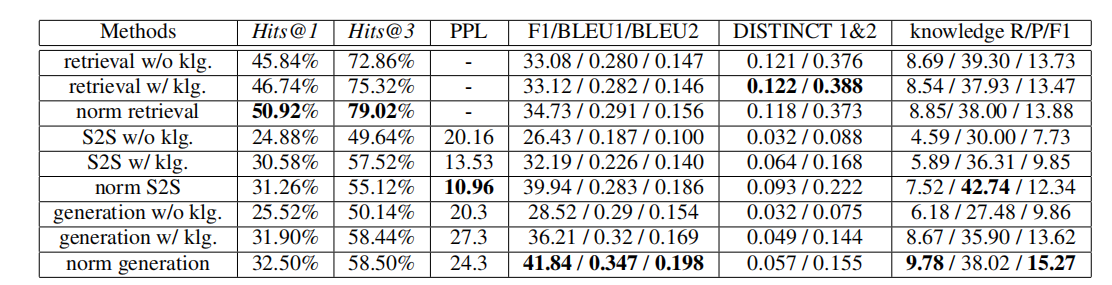

In [10]:
def eval(predict_file):
    import sys
    import math
    from collections import Counter


    def get_dict(tokens, ngram, gdict=None):
        token_dict = {}
        if gdict is not None:
            token_dict = gdict
        tlen = len(tokens)
        for i in range(0, tlen - ngram + 1):
            ngram_token = "".join(tokens[i:(i + ngram)])
            if token_dict.get(ngram_token) is not None:
                token_dict[ngram_token] += 1
            else:
                token_dict[ngram_token] = 1
        return token_dict

    def count(pred_tokens, gold_tokens, ngram, result):
        cover_count, total_count = result
        pred_dict = get_dict(pred_tokens, ngram)
        gold_dict = get_dict(gold_tokens, ngram)
        cur_cover_count = 0
        cur_total_count = 0
        for token, freq in pred_dict.items():
            if gold_dict.get(token) is not None:
                gold_freq = gold_dict[token]
                cur_cover_count += min(freq, gold_freq)
            cur_total_count += freq
        result[0] += cur_cover_count
        result[1] += cur_total_count
#对bp进行评估
    def calc_bp(pair_list):
        c_count = 0.0
        r_count = 0.0
        for pair in pair_list:
            pred_tokens, gold_tokens = pair
            c_count += len(pred_tokens)
            r_count += len(gold_tokens)
        bp = 1
        if c_count < r_count:
            bp = math.exp(1 - r_count / c_count)
        return bp
#对覆盖率进行评估
    def calc_cover_rate(pair_list, ngram):
        result = [0.0, 0.0]  # [cover_count, total_count]
        for pair in pair_list:
            pred_tokens, gold_tokens = pair
            count(pred_tokens, gold_tokens, ngram, result)
        cover_rate = result[0] / result[1]
        return cover_rate
#对belu进行评估
    def calc_bleu(pair_list):
        bp = calc_bp(pair_list)
        cover_rate1 = calc_cover_rate(pair_list, 1)
        cover_rate2 = calc_cover_rate(pair_list, 2)
        cover_rate3 = calc_cover_rate(pair_list, 3)
        bleu1 = 0
        bleu2 = 0
        bleu3 = 0
        if cover_rate1 > 0:
            bleu1 = bp * math.exp(math.log(cover_rate1))
        if cover_rate2 > 0:
            bleu2 = bp * math.exp((math.log(cover_rate1) + math.log(cover_rate2)) / 2)
        if cover_rate3 > 0:
            bleu3 = bp * math.exp((math.log(cover_rate1) + math.log(cover_rate2) + math.log(cover_rate3)) / 3)
        return [bleu1, bleu2]

    def calc_distinct_ngram(pair_list, ngram):
        ngram_total = 0.0
        ngram_distinct_count = 0.0
        pred_dict = {}
        for predict_tokens, _ in pair_list:
            get_dict(predict_tokens, ngram, pred_dict)
        for key, freq in pred_dict.items():
            ngram_total += freq
            ngram_distinct_count += 1
        return ngram_distinct_count / ngram_total

    def calc_distinct(pair_list):
        distinct1 = calc_distinct_ngram(pair_list, 1)
        distinct2 = calc_distinct_ngram(pair_list, 2)
        return [distinct1, distinct2]

    # 对指标f1进行评估
    def calc_f1(data):
        golden_char_total = 0.0
        pred_char_total = 0.0
        hit_char_total = 0.0
        for response, golden_response in data:
            golden_response = "".join(golden_response)
            response = "".join(response)
            common = Counter(response) & Counter(golden_response)
            hit_char_total += sum(common.values())
            golden_char_total += len(golden_response)
            pred_char_total += len(response)
        p = hit_char_total / pred_char_total
        r = hit_char_total / golden_char_total
        f1 = 2 * p * r / (p + r)
        return f1


    eval_file = predict_file
    sents = []
    for line in open(eval_file):
        tk = line.strip().split("\t")
        if len(tk) < 2:
            continue
        pred_tokens = tk[0].strip().split(" ")
        gold_tokens = tk[1].strip().split(" ")
        sents.append([pred_tokens, gold_tokens])
    f1 = calc_f1(sents)
    bleu1, bleu2 = calc_bleu(sents)
    distinct1, distinct2 = calc_distinct(sents)

    output_str = "F1: %.2f%%\n" % (f1 * 100)
    output_str += "BLEU1: %.3f%%\n" % bleu1
    output_str += "BLEU2: %.3f%%\n" % bleu2
    output_str += "DISTINCT1: %.3f%%\n" % distinct1
    output_str += "DISTINCT2: %.3f%%\n" % distinct2
    sys.stdout.write(output_str)

#### 对模型进行参数的设置并进行训练，并将训练出的模型文件存储到sava_model文件夹下，并且将每一次epoch的损失输出出来
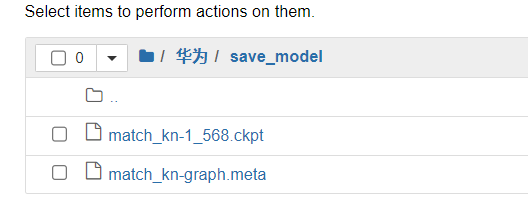
#### 论文中将其训练效果和基于生成的模型以及传统seq2seq模型比较结果如下图：
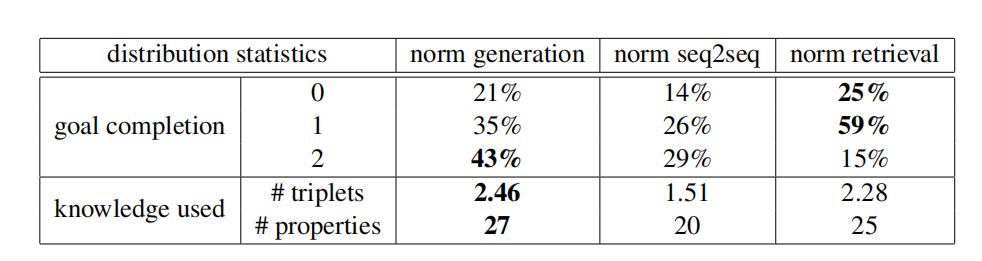

In [11]:
parser = argparse.ArgumentParser(description='train duconv') #创建解析器
#epoch = 10
task_name = 'match_kn' #任务名
#max_seq_length = 512
#batch_size = 8096 
vocab_size = 14373 #训练集词典大小
learning_rate = 0.1 #学习率
weight_decay = 0.01 #权重衰减
warmup_proportion = 0.1 #预热学习率
#train_data_file_path = ""
train_data_shuffle = "true"
#save_checkpoint_path = ""
epoch = 10 #epoch为训练所有数据的次数
max_seq_length = 256 #最大序列字数长度
batch_size = 32 #批大小
train_data_file_path = "./data/train.mindrecord" #文件的
save_checkpoint_path = "save_model/" #设置模型的存储路径
context.set_context(mode=context.GRAPH_MODE, max_call_depth=10000)
use_kn = "match_kn"
config = BertConfig(seq_length=max_seq_length, vocab_size=vocab_size)
dataset = create_dataset(batch_size, data_file_path=train_data_file_path,
                         do_shuffle=(train_data_shuffle.lower() == "true"), use_knowledge=use_kn)
steps_per_epoch = dataset.get_dataset_size()# 每个epoch的训练步数
print(steps_per_epoch)
max_train_steps = epoch * steps_per_epoch #最大训练步数
warmup_steps = int(max_train_steps * warmup_proportion)
keep_checkpoint = int(max_train_steps / 1000) + 1
network = RetrievalWithLoss(config, use_kn)
lr_schedule = Noam(config.hidden_size, warmup_steps, learning_rate)
optimizer = Adam(network.trainable_params(), lr_schedule) #神经网络优化器
network_one_step = TrainOneStepCell(network, optimizer) 
model = Model(network_one_step) #模型导入
ckpt_config = CheckpointConfig(save_checkpoint_steps=1000, keep_checkpoint_max=keep_checkpoint)
ckpoint_cb = ModelCheckpoint(prefix=task_name,
                             directory=None if save_checkpoint_path == "" else save_checkpoint_path,
                             config=ckpt_config)
callbacks = [TimeMonitor(100), LossMonitor(100), ckpoint_cb] #反向传播的设置
model.train(epoch, dataset, callbacks, dataset_sink_mode=False)

[WARNING] ME(114067:281473167599488,MainProcess):2022-10-24-15:34:13.398.9 [mindspore/dataset/core/validator_helpers.py:804] 'TypeCast' from mindspore.dataset.transforms.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'TypeCast' from mindspore.dataset.transforms instead.
[WARNING] ME(114067:281473167599488,MainProcess):2022-10-24-15:34:13.134.915 [mindspore/common/_decorator.py:38] 'MatMul' is deprecated from version 1.2 and will be removed in a future version, use 'ops.matmul' instead.


origin dataset size:  4550
142


[WARNING] ME(114067:281473167599488,MainProcess):2022-10-24-15:34:13.441.088 [mindspore/nn/layer/rnns.py:392] dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
[WARNING] DEVICE(114067,ffff942b2780,python):2022-10-24-15:34:30.437.256 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/network-RetrievalWithLoss/network-Retrieval/dropout-Dropout/DropoutGenMask-op1131] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(114067,ffff942b2780,python):2022-10-24-15:34:36.525.063 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/network-RetrievalWithLoss/network-Retrieval/bert-BertModel/encoder-BertEncoder/layers-CellList/3-BertEncoderLayer/enc_self_attn-MultiHeadAttention/attention-S

per step time: 1976.845 ms
epoch: 1 step: 100, loss is 0.569229006767273
per step time: 1968.847 ms
epoch: 2 step: 58, loss is 0.31487447023391724
per step time: 1969.923 ms
epoch: 3 step: 16, loss is 0.23625969886779785
per step time: 1970.439 ms
epoch: 3 step: 116, loss is 0.494729608297348
per step time: 1964.691 ms
epoch: 4 step: 74, loss is 0.3746311068534851
per step time: 1972.256 ms
epoch: 5 step: 32, loss is 0.4394373893737793
per step time: 1970.735 ms
epoch: 5 step: 132, loss is 0.16049614548683167
per step time: 1965.069 ms
epoch: 6 step: 90, loss is 0.4467563033103943
per step time: 1971.084 ms
epoch: 7 step: 48, loss is 0.24674645066261292
per step time: 1968.869 ms
epoch: 8 step: 6, loss is 0.19761240482330322
per step time: 1969.491 ms
epoch: 8 step: 106, loss is 0.31740424036979675
per step time: 1968.733 ms
epoch: 9 step: 64, loss is 0.24573644995689392
per step time: 1970.716 ms
epoch: 10 step: 22, loss is 0.5257401466369629
per step time: 1965.776 ms
epoch: 10 step:

#### 根据模型对测试集进行预测，预测过程中将评分(score.txt)和预测的对话(predict.txt)存储到output文件夹下
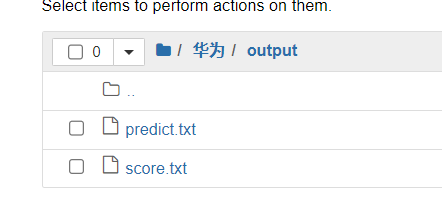
#### 下图为论文中三种模型生成对话的结果比较
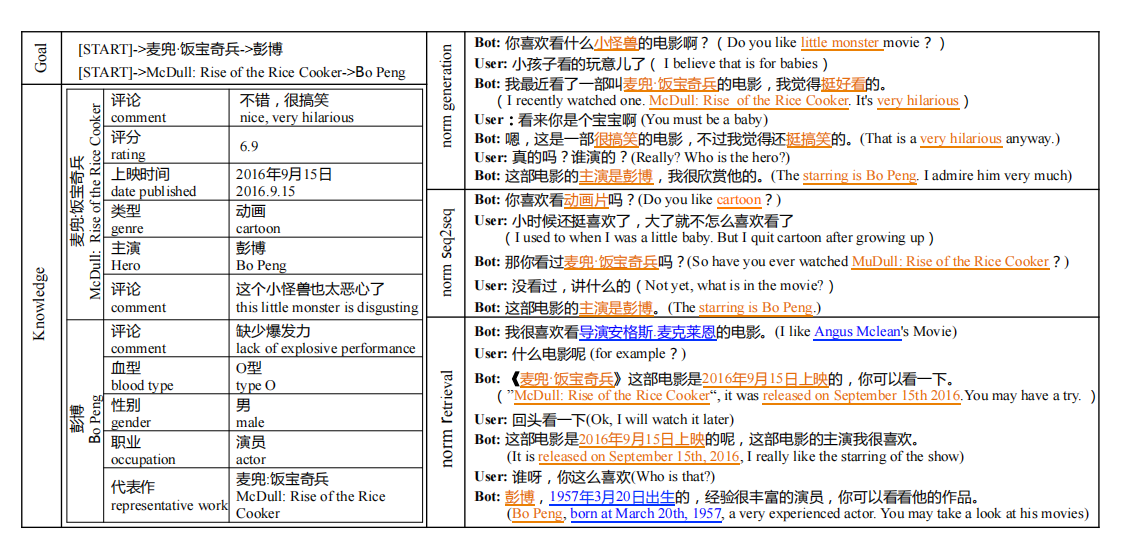

In [12]:
# 利用模型预测
if not os.path.exists('output'):#创建output文件夹
    os.makedirs('output')
parser = argparse.ArgumentParser(description='train duconv')
candidate_file = "data/candidate.test.txt" #候选回复的文件路径
score_file = "output/score.txt" #评分文件路径
predict_file = "output/predict.txt" #预测文件路径
load_checkpoint_path = "save_model/match_kn-10_142.ckpt" #模型的存储路径
task_name = "match_kn"
max_seq_length = 128 #输入序列最大单词数
batch_size = 1
eval_data_file_path = "data/test.mindrecord" #测试集路径
load_checkpoint_path = "save_model/match_kn-10_142.ckpt" #模型的存储路径
save_file_path = "output/score.txt"
vocab_size = 14373 #训练集词典大小
# args = parse_args()
context.set_context(mode=context.GRAPH_MODE, max_call_depth=10000)
use_kn = "match_kn"
config = BertConfig(seq_length=max_seq_length, vocab_size=vocab_size)
dataset = create_dataset(batch_size, data_file_path=eval_data_file_path,
                         do_shuffle=False, use_knowledge=use_kn) #创建数据集
steps_per_epoch = dataset.get_dataset_size()
print(steps_per_epoch)
network = RetrievalWithSoftmax(config, use_kn) #检索模型的网络设置
param_dict = load_checkpoint(load_checkpoint_path)
not_loaded = load_param_into_net(network, param_dict)
print(not_loaded)
network.set_train(False)
f = open(save_file_path, 'w') #打开评分文件score.txt
iterator = dataset.create_tuple_iterator()
for item in iterator:
    output = network(*item[:-1])
    for i in output:
        f.write(str(i[1]) + '\n')
        f.flush()
f.close()
extract_predict_utterance(candidate_file, score_file, predict_file) #将预测结果写入对应文件夹

[WARNING] ME(114067:281473167599488,MainProcess):2022-10-24-16:27:02.967.228 [mindspore/dataset/core/validator_helpers.py:804] 'TypeCast' from mindspore.dataset.transforms.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'TypeCast' from mindspore.dataset.transforms instead.


origin dataset size:  200
200


[WARNING] ME(114067:281473167599488,MainProcess):2022-10-24-16:27:03.386.841 [mindspore/nn/layer/rnns.py:392] dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1


[]


In [13]:
import sys
import math
from collections import Counter
def get_dict(tokens, ngram, gdict=None):
    token_dict = {}
    if gdict is not None:
        token_dict = gdict
    tlen = len(tokens)
    for i in range(0, tlen - ngram + 1):
        ngram_token = "".join(tokens[i:(i + ngram)])
        if token_dict.get(ngram_token) is not None:
            token_dict[ngram_token] += 1
        else:
            token_dict[ngram_token] = 1
    return token_dict

def count(pred_tokens, gold_tokens, ngram, result):
    cover_count, total_count = result
    pred_dict = get_dict(pred_tokens, ngram)
    gold_dict = get_dict(gold_tokens, ngram)
    cur_cover_count = 0
    cur_total_count = 0
    for token, freq in pred_dict.items():
        if gold_dict.get(token) is not None:
            gold_freq = gold_dict[token]
            cur_cover_count += min(freq, gold_freq)
        cur_total_count += freq
    result[0] += cur_cover_count
    result[1] += cur_total_count
#对bp进行评估
def calc_bp(pair_list):
    c_count = 0.0
    r_count = 0.0
    for pair in pair_list:
        pred_tokens, gold_tokens = pair
        c_count += len(pred_tokens)
        r_count += len(gold_tokens)
    bp = 1
    if c_count < r_count:
        bp = math.exp(1 - r_count / c_count)
    return bp
#对覆盖率进行评估
def calc_cover_rate(pair_list, ngram):
    result = [0.0, 0.0]  # [cover_count, total_count]
    for pair in pair_list:
        pred_tokens, gold_tokens = pair
        count(pred_tokens, gold_tokens, ngram, result)
    cover_rate = result[0] / result[1]
    return cover_rate
#对belu进行评估
def calc_bleu(pair_list):
    bp = calc_bp(pair_list)
    cover_rate1 = calc_cover_rate(pair_list, 1)
    cover_rate2 = calc_cover_rate(pair_list, 2)
    cover_rate3 = calc_cover_rate(pair_list, 3)
    bleu1 = 0
    bleu2 = 0
    bleu3 = 0
    if cover_rate1 > 0:
        bleu1 = bp * math.exp(math.log(cover_rate1))
    if cover_rate2 > 0:
        bleu2 = bp * math.exp((math.log(cover_rate1) + math.log(cover_rate2)) / 2)
    if cover_rate3 > 0:
        bleu3 = bp * math.exp((math.log(cover_rate1) + math.log(cover_rate2) + math.log(cover_rate3)) / 3)
    return [bleu1, bleu2]

def calc_distinct_ngram(pair_list, ngram):
    ngram_total = 0.0
    ngram_distinct_count = 0.0
    pred_dict = {}
    for predict_tokens, _ in pair_list:
        get_dict(predict_tokens, ngram, pred_dict)
    for key, freq in pred_dict.items():
        ngram_total += freq
        ngram_distinct_count += 1
    return ngram_distinct_count / ngram_total

def calc_distinct(pair_list):
    distinct1 = calc_distinct_ngram(pair_list, 1)
    distinct2 = calc_distinct_ngram(pair_list, 2)
    return [distinct1, distinct2]

# 对指标f1进行评估
def calc_f1(data):
    golden_char_total = 0.0
    pred_char_total = 0.0
    hit_char_total = 0.0
    for response, golden_response in data:
        golden_response = "".join(golden_response)
        response = "".join(response)
        common = Counter(response) & Counter(golden_response)
        hit_char_total += sum(common.values())
        golden_char_total += len(golden_response)
        pred_char_total += len(response)
    p = hit_char_total / pred_char_total
    r = hit_char_total / golden_char_total
    f1 = 2 * p * r / (p + r)
    return f1


eval_file = predict_file
sents = []
for line in open(eval_file, encoding = "utf-8"):
    tk = line.strip().split("\t")
    if len(tk) < 2:
        continue
    pred_tokens = tk[0].strip().split(" ")
    gold_tokens = tk[1].strip().split(" ")
    sents.append([pred_tokens, gold_tokens])
# calc f1
f1 = calc_f1(sents)
# calc bleu
bleu1, bleu2 = calc_bleu(sents)
# calc distinct
distinct1, distinct2 = calc_distinct(sents)

output_str = "F1: %.2f%%\n" % (f1 * 100)
output_str += "BLEU1: %.3f%%\n" % bleu1
output_str += "BLEU2: %.3f%%\n" % bleu2
output_str += "DISTINCT1: %.3f%%\n" % distinct1
output_str += "DISTINCT2: %.3f%%\n" % distinct2
sys.stdout.write(output_str)


F1: 26.83%
BLEU1: 0.225%
BLEU2: 0.124%
DISTINCT1: 0.458%
DISTINCT2: 0.800%


75